# Lab 2: Bayesian Regression

### 12th February 2014 Gaussian Process Road Show, Pereira, Colombia¶

## written by Neil Lawrence

As normal, let's first get the plots running in line on the  notebook.
$$\newcommand{\inputScalar}{x}
\newcommand{\lengthScale}{\ell}
\newcommand{\mappingVector}{\mathbf{w}}
\newcommand{\gaussianDist}[3]{\mathcal{N}\left(#1|#2,#3\right)}
\newcommand{\gaussianSamp}[2]{\mathcal{N}\left(#1,#2\right)}
\newcommand{\zerosVector}{\mathbf{0}}
\newcommand{\eye}{\mathbf{I}}
\newcommand{\dataStd}{\sigma}
\newcommand{\dataScalar}{y}
\newcommand{\dataVector}{\mathbf{y}}
\newcommand{\dataMatrix}{\mathbf{Y}}
\newcommand{\noiseScalar}{\epsilon}
\newcommand{\noiseVector}{\mathbf{\epsilon}}
\newcommand{\noiseMatrix}{\mathbf{\Epsilon}}
\newcommand{\inputVector}{\mathbf{x}}
\newcommand{\kernelScalar}{k}
\newcommand{\ltwoNorm}[1]{\left\Vert#1\right\Vert_2}
\newcommand{\kernelMatrix}{\mathbf{K}}
\newcommand{\basisMatrix}{\mathbf{\Phi}}
\newcommand{\basisVector}{\mathbf{\phi}}
\newcommand{\basisScalar}{\phi}
\newcommand{\expSamp}[1]{\left<#1\right>}
\newcommand{\expDist}[2]{\left<#1\right>_{#2}}
\newcommand{\covarianceMatrix}{\mathbf{C}}
\newcommand{\numData}{N}
\newcommand{\mappingScalar}{w}
\newcommand{\mappingFunctionScalar}{f}
\newcommand{\mappingFunctionVector}{\mathbf{f}}
\newcommand{\meanVector}{\boldsymbol{\mu}}
\newcommand{\meanScalar}{\mu}$$

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The next thing to do is to download the olympics data just to make sure it is available for us to study.

In [2]:
import urllib
url = ("http://staffwww.dcs.shef.ac.uk/"
    + "people/N.Lawrence/dataset_mirror/"
    + "olympic_marathon_men/olympicMarathonTimes.csv")
urllib.urlretrieve(url, 'olympicMarathonTimes.csv')
olympics = np.loadtxt('olympicMarathonTimes.csv', delimiter=',')  

The aim of this notebook is to study Bayesian approaches to regression. As in previous sessions, first extract both the olympic years and the pace of the winning runner into 2-dimensional arrays with the data points in the rows of the array (the first dimension).

In [3]:
x = olympics[:, 0:1]
y = olympics[:, 1:2]

We can plot them to check that they've loaded in correctly.


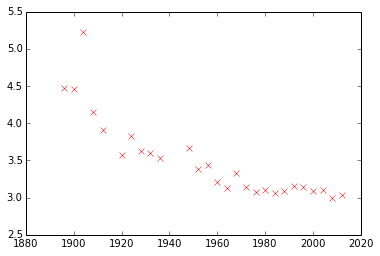

In [4]:
plt.plot(x, y, 'rx')

## The Prior Distribution

In the Bayesian approach, the first thing we do is assume a prior distribution for the parameters, $\mappingVector$. In the lectures we took this prior to be 

$$\mappingVector \sim \gaussianSamp{\zerosVector}{\alpha \eye}$$

In other words, we assumed for the prior that each element of the parameters vector, $\mappingScalar_i$, was drawn from a Gaussian density as follows

$$\mappingScalar_i \sim \gaussianSamp{0}{\alpha}$$

Let's start by assigning the parameter of the prior distribution, which is the variance of the prior distribution, $\alpha$.

In [5]:
# set prior variance on w
alpha = 4.
# set the order of the polynomial basis set
order = 5
# set the noise variance
sigma2 = 0.01

Now we have the prior variance, we can sample from the prior distribution to see what form we are imposing on the functions *a priori*. To do this, we first sample a weight vector, then we multiply that weight vector by our basis to compute the the functions. Firstly we compute the basis function matrix. We will do it both for our training data, and for a range of prediction locations (`x_pred`). 

In [6]:
num_data = x.shape[0]
num_pred_data = 100 # how many points to use for plotting predictions
x_pred = linspace(1890, 2016, num_pred_data)[:, None] # input locations for predictions

now let's build the basis matrices.


In [7]:
# build the basis set
Phi = np.zeros((num_data, order+1))
Phi_pred = np.zeros((num_pred_data, order+1))
for i in xrange(0, order+1):
    Phi[:, i:i+1] = x**i
    Phi_pred[:, i:i+1] = x_pred**i

### Sampling from the Prior

Now we will sample from the prior to produce a vector $\mappingVector$ and use it to plot a function which is representative of our belief *before* we fit the data. To do this we are going to use the properties of the Gaussian density and a sample from a *standard normal* using the function `np.random.normal`.

### Scaling Gaussian-distributed Variables

First, let's consider the case where we have one data point and one feature in our basis set. In otherwords $\mappingFunctionVector$ would be a scalar, $\mappingVector$ would be a scalar and $\basisMatrix$ would be a scalar. In this case we have 

$$\mappingFunctionScalar = \basisScalar \mappingScalar$$

If $\mappingScalar$ is drawn from a normal density, 

$$\mappingScalar \sim \gaussianSamp{\meanScalar_\mappingScalar}{c_\mappingScalar}$$

and $\basisScalar$ is a scalar value which we are given, then properties of the Gaussian density tell us that 

$$\basisScalar \mappingScalar \sim \gaussianSamp{\basisScalar\meanScalar_\mappingScalar}{\basisScalar^2c_\mappingScalar}$$

Let's test this out numerically. First we will draw 200 samples from a standard normal,

In [8]:
w_vec = np.random.normal(size=200)

We can compute the mean of these samples and their variance

In [9]:
print 'w sample mean is ', w_vec.mean()
print 'w sample variance is ', w_vec.var()

w sample mean is  0.0820984211257
w sample variance is  0.919309406164


These are close to zero (the mean) and one (the variance) as you'd expect. Now compute the mean and variance of the scaled version,

In [10]:
phi = 7
f_vec = phi*w_vec
print 'True mean should be phi*0 = 0.'
print 'True variance should be phi*phi*1 = ', phi*phi
print 'f sample mean is ', f_vec.mean()
print 'f sample variance is ', f_vec.var()

True mean should be phi*0 = 0.
True variance should be phi*phi*1 =  49
f sample mean is  0.57468894788
f sample variance is  45.046160902


If you increase the number of samples then you will see that the sample mean and the sample variance begin to converge towards the true mean and the true variance. Obviously adding an offset to a sample from `np.random.normal` will change the mean. So if you want to sample from a Gaussian with mean `mu` and standard deviation `sigma` one way of doing it is to sample from the standard normal and scale and shift the result, so to sample a set of $\mappingScalar$ from a Gaussian with mean $\meanScalar$ and variance $\alpha$,

$$w \sim \gaussianSamp{\meanScalar}{\alpha}$$

We can simply scale and offset samples from the *standard normal*.

In [11]:
mu = 4 # mean of the distribution
alpha = 2 # variance of the distribution
w_vec = np.random.normal(size=200)*np.sqrt(alpha) + mu
print 'w sample mean is ', w_vec.mean()
print 'w sample variance is ', w_vec.var()

w sample mean is  4.11056281772
w sample variance is  1.8774274887


Here the `np.sqrt` is necesssary because we need to multiply by the standard deviation and we specified the variance as `alpha`. So scaling and offsetting a Gaussian distributed variable keeps the variable Gaussian, but it effects the mean and variance of the resulting variable. 

To get an idea of the overal shape of the resulting distribution, let's do the same thing with a histogram of the results. 

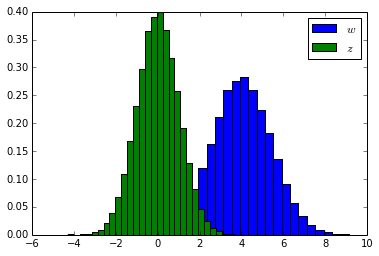

In [12]:
# First the standard normal
z_vec = np.random.normal(size=100000) # by convention, in statistics, z is often used to denote samples from the standard normal
w_vec = z_vec*np.sqrt(alpha) + mu
# plot normalized histogram of w, and then normalized histogram of z on top
plt.hist(w_vec, bins=30, normed=True)
plt.hist(z_vec, bins=30, normed=True)
plt.legend(('$w$', '$z$'))

Now re-run this histogram with 100,000 samples and check that the both histograms look qualitatively Gaussian.

## Sampling from the Prior

Let's use this way of constructing samples from a Gaussian to check what functions look like *a priori*. The process will be as follows. First, we sample a random vector $K$ dimensional from `np.random.normal`. Then we scale it by $\sqrt{\alpha}$ to obtain a prior sample of $\mappingVector$.  

In [13]:
K = order + 1
z_vec = np.random.normal(size=K)
w_sample = z_vec*np.sqrt(alpha)
print w_sample

[-0.28442214 -0.18152291 -1.40796919  1.34304818  0.50221486  0.49309476]


Now we can combine our sample from the prior with the basis functions to create a function,

(100, 6) (6,)


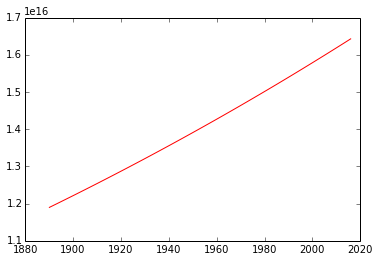

In [14]:
f_sample = np.dot(Phi_pred,w_sample)
print Phi_pred.shape, w_sample.shape
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')

This shows the recurring problem with the polynomial basis. Our prior allows relatively large coefficients for the basis associated with high polynomial degrees. Because we are operating with input values of around 2000, this leads to output functions of very high values. One fix for this is to rescale our inputs to be between -1 and 1 before applying the model. This is a disadvantage of the polynomial basis. Let's rescale x and x_pred now.

In [15]:
span = np.max(x) - np.min(x) 
offset = np.min(x)
x -= offset
x_pred -= offset
x /= span # x is now between zero and 1
x_pred /= span 
x = x*2-1 # x is now between -1 and 1
x_pred = x_pred*2 - 1 

Now we need to recompute the basis functions from above, 

In [16]:
# rebuild the basis set
Phi = np.zeros((num_data, order+1))
Phi_pred = np.zeros((num_pred_data, order+1))
for i in xrange(0, order+1):
    Phi[:, i:i+1] = x**i
    Phi_pred[:, i:i+1] = x_pred**i

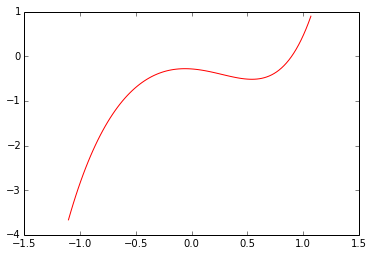

In [17]:
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')

Now let's loop through some samples and plot various functions as samples from this system,

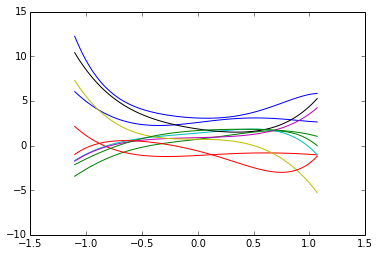

In [18]:
num_samples = 10
K = order+1
for i in xrange(num_samples):
    z_vec = np.random.normal(size=K)
    w_sample = z_vec*np.sqrt(alpha)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred.flatten(), f_sample.flatten())


The predictions for the mean output can now be computed. We want the expected value of the predictions under the posterior distribution. In matrix form, the predictions can be computed as

$$\mathbf{f} = \basisMatrix \mappingVector.$$

This involves a matrix multiplication between a fixed matrix $\basisMatrix$ and a vector that is drawn from a distribution $\mappingVector$. Because $\mappingVector$ is drawn from a distribution, this imples that $\mappingFunctionVector$ should also be drawn from a distribution. Let's work out what that distributions should be. 

## Computing the Posterior

In the lecture we went through how to compute the posterior distribution for $\mappingVector$. This distribution is also Gaussian,

$$p(\mappingVector | \dataVector, \inputVector, \dataStd^2) = \mathcal{N}\left(\mappingVector|\meanVector_\mappingScalar, \covarianceMatrix_\mappingScalar\right)$$

with covariance, $\covarianceMatrix_\mappingScalar$, given by

$$\covarianceMatrix_\mappingScalar = \left(\dataStd^{-2}\basisMatrix^\top \basisMatrix + \alpha^{-1} \eye\right)^{-1}$$ 

whilst the mean is given by

$$\meanVector_\mappingScalar = \covarianceMatrix_\mappingScalar \dataStd^{-2}\basisMatrix^\top \dataVector$$

Let's compute the posterior covariance and mean, then we'll sample from these densities to have a look at the posterior belief about $\mappingVector$ once the data has been accounted for. Remember, the process of Bayesian inference involves combining the prior, $p(\mappingVector)$ with the likelihood, $p(\dataVector|\inputVector, \mappingVector)$ to form the posterior, $p(\mappingVector | \dataVector, \inputVector)$ through Bayes' rule,

$$p(\mappingVector|\dataVector, \inputVector) = \frac{p(\dataVector|\inputVector, \mappingVector)p(\mappingVector)}{p(\dataVector)}$$

We've looked at the samples for our function $\mappingFunctionVector = \basisMatrix\mappingVector$, which forms the mean of the Gaussian likelihood, under the prior distribution. I.e. we've sampled from $p(\mappingVector)$ and multiplied the result by the basis matrix. Now we will sample from the posterior density, $p(\mappingVector|\dataVector, \inputVector)$, and check that the new samples fit do correspond to the data, i.e. we want to check that the updated distribution includes information from the data set. First we need to compute the posterior mean and *covariance*.

In [19]:
# compute the posterior covariance and mean
w_cov = np.linalg.inv(1/sigma2*np.dot(Phi.T, Phi) + 1/alpha*np.eye(order+1))
w_mean = np.dot(w_cov, 1/sigma2*np.dot(Phi.T, y))

Before we were able to sample the prior values for the mean *independently* from a Gaussian using `np.random.normal` and scaling the result. However, observing the data *correlates* the parameters. Recall this from the first lab where we had a correlation between the offset, $c$ and the slope $m$ which caused such problems with the coordinate ascent algorithm. We need to sample from a *correlated* Gaussian. For this we can use `np.random.multivariate_normal`.

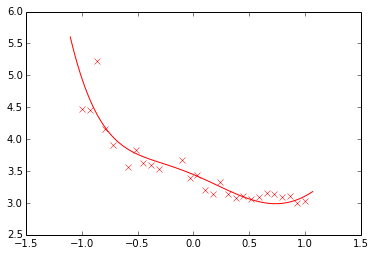

In [20]:
w_sample = np.random.multivariate_normal(w_mean.flatten(), w_cov)
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')
plt.plot(x, y, 'rx') # plot data to show fit.

Now let's sample several functions and plot them all to see how the predictions fluctuate.

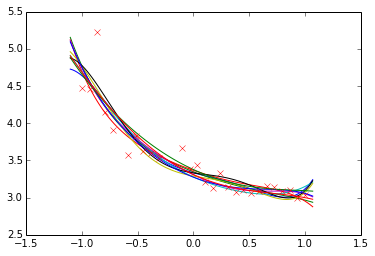

In [21]:
for i in xrange(num_samples):
    w_sample = np.random.multivariate_normal(w_mean.flatten(), w_cov)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred.flatten(), f_sample.flatten())
plt.plot(x, y, 'rx') # plot data to show fit.

### Sum of Gaussian-distributed Variables

The sum of Gaussian random variables is also Gaussian, so if we have a random variable $y_i$ drawn from a Gaussian density with mean $\meanScalar_i$ and variance $\dataStd^2_i$, 

$$y_i \sim \gaussianSamp{\meanScalar_i}{\dataStd^2_i}$$

Then the sum of $K$ independently sampled values of $y_i$ will be drawn from a Gaussian with mean $\sum_{i=1}^K \mu_i$ and variance $\sum_{i=1}^K \dataStd_i^2$,


$$\sum_{i=1}^K y_i \sim \gaussianSamp{\sum_{i=1}^K \meanScalar_i}{\sum_{i=1}^K \dataStd_i^2}.$$

Let's try that experimentally. First let's generate a vector of samples from a standard normal distribution, $z \sim \gaussianSamp{0}{1}$,  then we will scale and offset them, then keep adding them into a vector `y_vec`.

In [22]:
K = 10 # how many Gaussians to add.
num_samples = 1000 # how many samples to have in y_vec
mus = np.linspace(0, 5, K) # mean values generated linearly spaced between 0 and 5
sigmas = np.linspace(0.5, 2, K) # sigmas generated linearly spaced between 0.5 and 2
y_vec = np.zeros(num_samples)
for mu, sigma in zip(mus, sigmas):
    z_vec = np.random.normal(size=num_samples) # z is from standard normal
    y_vec += z_vec*sigma + mu # add to y z*sigma + mu

# now y_vec is the sum of each scaled and off set z.
print 'Sample mean is ', y_vec.mean(), ' and sample variance is ', y_vec.var()
print 'True mean should be ', mus.sum()
print 'True variance should be ', (sigmas**2).sum(), ' standard deviation ', np.sqrt((sigmas**2).sum()) 

Sample mean is  25.3544646581  and sample variance is  17.7696805246
True mean should be  25.0
True variance should be  17.9166666667  standard deviation  4.2328083664


Of course, we can histogram `y_vec` as well.

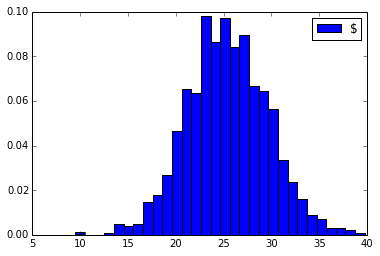

In [23]:
plt.hist(y_vec, bins=30, normed=True)
plt.legend('$y$')

### Matrix Multiplication of Gaussian Variables

Matrix multiplication is just adding and scaling together, in the formula, $\mappingFunctionVector = \basisMatrix \mappingVector$ we can extract the first element from $\mappingFunctionVector$ as

$$\mappingFunctionScalar_i = \basisVector_i^\top \mappingVector$$

where $\basisVector$ is a column vector from the $i$th row of $\basisMatrix$ and $\mappingFunctionScalar_i$ is the $i$th element of $\mappingFunctionVector$. This vector inner product itself merely implies that 

$$\mappingFunctionScalar_i = \sum_{j=1}^K \mappingScalar_j \basisScalar_{i, j}$$

and if we now say that $\mappingScalar_i$ is Gaussian distributed, then because a scaled Gaussian is also Gaussian, and because a sum of Gaussians is also Gaussian, we know that $\mappingFunctionScalar_i$ is also Gaussian distributed. It merely remains to work out its mean and covariance. We can do this by looking at the expectation under a Gaussian distribution. The expectation of the mean vector is given by

$$\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \int \mappingFunctionVector \gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix} \text{d}\mappingVector = \int \basisMatrix\mappingVector \gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix} \text{d}\mappingVector = \basisMatrix \int \mappingVector \gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix} \text{d}\mappingVector = \basisMatrix \meanVector$$

Which is straightforward. The expectation of $\mappingFunctionVector=\basisMatrix\mappingVector$ under the Gaussian distribution for $\mappingFunctionVector$ is simply $\mappingFunctionVector=\basisMatrix\meanVector$, where $\meanVector$ is the *mean* of the Gaussian density for $\mappingVector$. Because our prior distribution was Gaussian with zero mean, the expectation under the prior is given by

$$\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\zerosVector}{\alpha\eye}} = \zerosVector$$

The covariance is a little more complicated. A covariance matrix is defined as

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \expDist{\mappingFunctionVector\mappingFunctionVector^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} - \expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}}\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}}^\top$$

we've already computed $\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}}=\basisMatrix \meanVector$ so we can substitute that in to recover

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \expDist{\mappingFunctionVector\mappingFunctionVector^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} - \basisMatrix \meanVector \meanVector^\top \basisMatrix^\top$$

So we need the expectation of $\mappingFunctionVector\mappingFunctionVector^\top$. Substituting in $\mappingFunctionVector = \basisMatrix \mappingVector$ we have

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \expDist{\basisMatrix\mappingVector\mappingVector^\top \basisMatrix^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} - \basisMatrix \meanVector \meanVector^\top \basisMatrix^\top$$

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \basisMatrix\expDist{\mappingVector\mappingVector^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} \basisMatrix^\top - \basisMatrix \meanVector \meanVector^\top \basisMatrix^\top$$

Which is dependent on the second moment of the Gaussian,

$$\expDist{\mappingVector\mappingVector^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \covarianceMatrix + \meanVector\meanVector^\top$$

that can be substituted in to recover,

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \basisMatrix\covarianceMatrix \basisMatrix^\top$$

so in the case of the prior distribution, where we have $\covarianceMatrix = \alpha \eye$ we can write

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\zerosVector}{\alpha \eye}} = \alpha \basisMatrix \basisMatrix^\top$$

This implies that the prior we have suggested for $\mappingVector$, which is Gaussian with a mean of zero and covariance of $\alpha \eye$ suggests that the distribution for $\mappingVector$ is also Gaussian with a mean of zero and covariance of $\alpha \basisMatrix\basisMatrix^\top$. Since our observed output, $\dataVector$, is given by a noise corrupted variation of $\mappingFunctionVector$, the final distribution for $\dataVector$ is given as 

$$\dataVector = \mappingFunctionVector + \noiseVector$$

where the noise, $\noiseVector$, is sampled from a Gaussian density: $\noiseVector \sim \gaussianSamp{\zerosVector}{\dataStd^2\eye}$. So, in other words, we are taking a Gaussian distributed random value $\mappingFunctionVector$,

$$\mappingFunctionVector \sim \gaussianSamp{\zerosVector}{\alpha\basisMatrix\basisMatrix^\top}$$

and adding to it another Gaussian distributed value, $\noiseVector \sim \gaussianSamp{\zerosVector}{\dataStd^2\eye}$, to form our data observations, $\dataVector$. Once again the sum of two (multivariate) Gaussian distributed variables is also Gaussian, with a mean given by the sum of the means (both zero in this case) and the covariance given by the sum of the covariances. So we now have that the marginal likelihood for the data, $p(\dataVector)$ is given by

$$p(\dataVector) = \gaussianDist{\dataVector}{\zerosVector}{\alpha \basisMatrix \basisMatrix^\top + \dataStd^2\eye}$$

This is our *implicit* assumption for $\dataVector$ given our prior assumption for $\mappingVector$.

### Computing the Mean and Error Bars of the Functions

You should now know enough to compute the mean of the predictions under the posterior density. 

In [24]:
# compute mean under posterior density
f_pred_mean = np.dot(Phi_pred, w_mean)

We can plot these predictions alongside the real data,

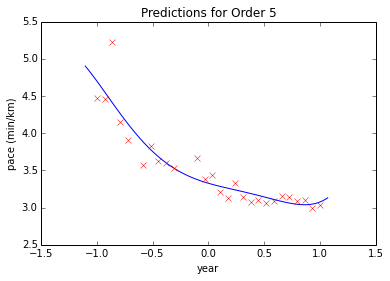

In [25]:
# print the error and plot the predictions
plt.plot(x_pred, f_pred_mean)
plt.plot(x, y, 'rx')
ax = plt.gca()
ax.set_title('Predictions for Order ' + str(order))
ax.set_xlabel('year')
ax.set_ylabel('pace (min/km)')

### Computing the Error

We can also compute what the training error was. First compute the expected output under the posterior density,

In [26]:
f_mean = np.dot(Phi, w_mean)

These can be used to compute the error

$$E(\mappingVector) =  \frac{\numData}{2} \log \dataStd^2 + \frac{1}{2\dataStd^2} \sum_{i=1}^\numData \left(\dataScalar_i - \mappingVector^\top \phi(\inputVector_i)\right)^2 \\\
E(\mappingVector) = \frac{\numData}{2} \log \dataStd^2 + \frac{1}{2\dataStd^2} \sum_{i=1}^\numData \left(\dataScalar_i - \mappingFunctionScalar_i\right)^2$$

In [27]:
# compute the sum of squares term
sum_squares = ((y-f_mean)**2).sum()
# fit the noise variance
error = (num_data/2*np.log(sigma2) + sum_squares/(2*sigma2))
print 'The error is: ',error

The error is:  -6.26873167309


Now we have the fit and the error, let's plot the fit and the error.

## Computing Error Bars

Finally, we can compute error bars for the predictions. The error bars are the standard deviations of the predictions for $\mappingFunctionVector=\basisMatrix\mappingVector$ under the posterior density for $\mappingVector$. The standard deviations of these predictions can be found from the variance of the prediction at each point. Those variances are the diagonal entries of the covariance matrix. We've already computed the form of the covariance under Gaussian expectations, 

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \basisMatrix\covarianceMatrix \basisMatrix^\top$$

which under the posterior density is given by

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector_w}{\covarianceMatrix_w}} = \basisMatrix\covarianceMatrix_w \basisMatrix^\top$$

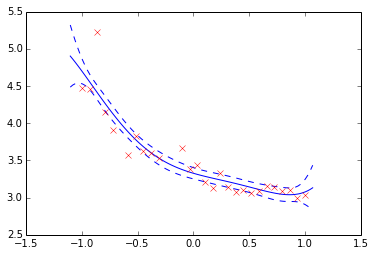

In [28]:
# compute the error bars
f_pred_cov = np.dot(Phi_pred, np.dot(w_cov, Phi_pred.T))
f_pred_var = np.diag(f_pred_cov)[:, None]
f_pred_std = np.sqrt(f_pred_var)

# plot mean, and error bars at 2 standard deviations
plt.plot(x_pred.flatten(), f_pred_mean.flatten(), 'b-')
plt.plot(x_pred.flatten(), (f_pred_mean+2*f_pred_std).flatten(), 'b--')
plt.plot(x_pred.flatten(), (f_pred_mean-2*f_pred_std).flatten(), 'b--')
plt.plot(x, y, 'rx')

### Gaussian Processes

Now we're going to build on our understanding of the marginal likelihood we derived in the lectures, and also across the last part of the lab, to try and see the relationship with Gaussian procces. In the last lab section we sampled directly from the weight vector $\mappingVector$ and applied it to the basis matrix $\basisMatrix$ to obtain a sample from the prior and a sample from the posterior. Now we'll start by constructing the prior directly, rather than sampling the weights and then combining with the basis.

## Sampling from the Prior

The first thing we'll do is to set up the parameters of the model, these include the parameters of the prior, the parameters of the basis functions and the noise level.

$$\mappingVector \sim \gaussianSamp{\zerosVector}{\alpha \eye}$$

In [29]:
# set prior variance on w
alpha = 4.
# set the order of the polynomial basis set
order = 5
# set the noise variance
sigma2 = 0.01

Now we have the variance, we can sample from the prior distribution to see what form we are imposing on the functions *a priori*. 

Before we sample from our prior, recall the problems with the basis set from our last lab: the basis doesn't work well when predictions are made outside the $-1, 1$ region. Let's rescale the data to be within that region.

In [30]:
span = np.max(x) - np.min(x) 
offset = np.min(x)
x -= offset
x /= span # x is now between zero and 1
x = x*2-1 # x is now between -1 and 1

Let's now compute a range of values to make predictions at, spanning the *new* space of inputs,

In [31]:
num_data = x.shape[0]
num_pred_data = 100 # how many points to use for plotting predictions
x_pred = linspace(-1.2, 1.2, num_pred_data)[:, None] # input locations for predictions

now let's build the basis matrices.


In [32]:
# build the basis set
Phi = np.zeros((num_data, order+1))
Phi_pred = np.zeros((num_pred_data, order+1))
for i in range(0, order+1):
    Phi[:, i:i+1] = x**i
    Phi_pred[:, i:i+1] = x_pred**i

### Weight Space View

Now we will sample from the prior density to obtain a vector $\mappingVector$ using the function `np.random.normal` and combine with our basis to create 10 samples from the model over functions,

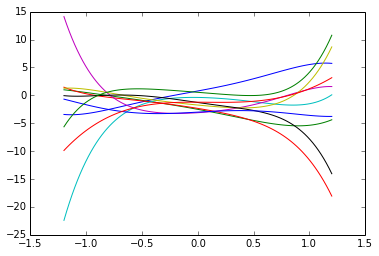

In [33]:
num_samples = 10
K = order+1
for i in xrange(num_samples):
    z_vec = np.random.normal(size=K)
    w_sample = z_vec*np.sqrt(alpha)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred.flatten(), f_sample.flatten())


### Function Space View

The process we have used to generate the samples is a two stage process. To obtain each function, we first generated a sample from the prior,

$$\mappingVector \sim \gaussianSamp{\zerosVector}{\alpha \eye}$$

We next applied the likelihood. The mean of the function in the likelihood is given by

$$\mathbf{f} = \basisMatrix \mappingVector.$$

so we plotted the result. In the lecture we talked about computing the marginal likelihood directly. We used properties of Gaussian densities to show that,

$$\mappingFunctionVector \sim \gaussianSamp{\zerosVector}{\alpha \basisMatrix \basisMatrix^\top},$$

so we should be able to sample directly from this density. To do that we use the `np.random.multivariate_normal` command introduced in the last session. We need to sample from a multivariate normal with covariance given by $\alpha\basisMatrix\basisMatrix^\top$ and a zero mean,

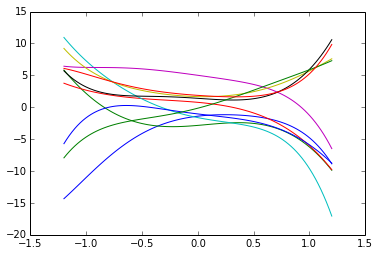

In [34]:
K = alpha*np.dot(Phi_pred, Phi_pred.T)
for i in xrange(10):
    f_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), f_sample.flatten())

We can plot the covariance given as an image in python with a colorbar to show scale.

<matplotlib.colorbar.Colorbar instance at 0x7fe755bc7b48>

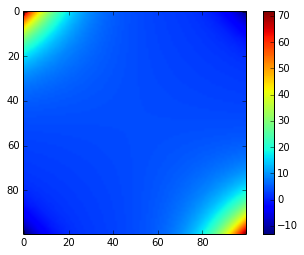

In [35]:
plt.imshow(K)
plt.colorbar()

Because the full model involves corrupting the latent function with Gaussian noise,

$$\dataVector = \mappingFunctionVector + \noiseVector$$

and the noise is sampled from an independent Gaussian distribution with variance $\dataStd^2$,

$$\noiseVector \sim \gaussianSamp{\zerosVector}{\dataStd^2 \eye},$$

we can use properties of Gaussian variables, i.e. the fact that sum of two Gaussian variables is also Gaussian, and that it's covariance is given by the sum of the two covariances, whilst the mean is given by the sum of the means, to write down the marginal likelihood,

$$\dataScalar \sim \gaussianSamp{\zerosVector}{\alpha \basisMatrix \basisMatrix^\top + \dataStd^2 \eye}$$.

Sampling directly from this distribution gives us the noise corrupted functions,

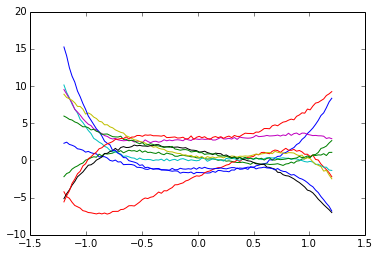

In [36]:
K = alpha*np.dot(Phi_pred, Phi_pred.T) + sigma2*np.eye(x_pred.size)
for i in xrange(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

Here we can see the small effect of our noise value, $\dataStd^2$. We can increase the noise value to see a different effect,

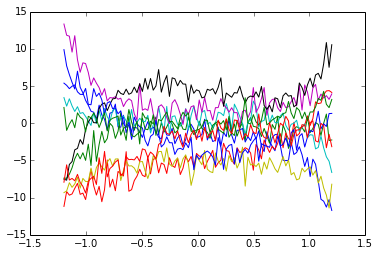

In [37]:
sigma2 = 1.
K = alpha*np.dot(Phi_pred, Phi_pred.T) + sigma2*np.eye(x_pred.size)
for i in xrange(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

#### Function Space Reflection

How would you include the noise term when sampling in the weight space point of view?

## Gaussian Process

Rather than sampling from the prior over parameters, we sampled from the marginal likelihood. Specifying this marginal likelihood directly, and avoiding the intermediate weight-space representation is what Gaussian processes are all about. In a Gaussian process you specify the *covariance function* directly, rather than *implicitly* through a basis matrix and a prior over parameters. Gaussian processes have the advantage that they can be *nonparametric*, which in simple terms means that they can have *infinite* basis functions. In the lectures we introduced the *exponentiated quadratic* covariance, also known as the RBF or the Gaussian or the squared exponential covariance function. This covariance function is specified by

$$\kernelScalar(\inputVector_i, \inputVector_j) = \alpha \exp\left( -\frac{\ltwoNorm{\inputVector_i-\inputVector_j}^2}{2\lengthScale^2}\right).$$

where $\ltwoNorm{\inputVector_i-\inputVector_j}^2$ is the squared distance between the two input vectors 

Let's build a covariance matrix based on this function. We will compute the covariance at the points given by `x_pred`

In [45]:
import urllib
url = ("http://staffwww.dcs.shef.ac.uk/"
    + "people/N.Lawrence/dataset_mirror/"
    + "olympic_marathon_men/olympicMarathonTimes.csv")
urllib.urlretrieve(url, 'olympicMarathonTimes.csv')
olympics = np.loadtxt('olympicMarathonTimes.csv', delimiter=',')
x = olympics[:, 0:1]
#x_pred = linspace(1892, 2016, num_pred_data)[:, None]
x_pred = linspace(0, 4, num_pred_data)[:, None]

In [46]:
def kern(x, xprime, variance=1.0, lengthscale=1.0):
    return 64*np.exp((-0.5*(x - xprime)**2)/lengthscale**2) + 16*min(x, xprime) + 64*x*xprime
    
alpha = 1.0
lengthscale = 1
K = np.zeros((x_pred.size, x_pred.size))
for i in xrange(x_pred.size):
    for j in xrange(x_pred.size):
        K[i, j] = kern(x_pred[i], x_pred[j], variance=alpha, lengthscale=lengthscale)


Now we can image the resulting covariance,

<matplotlib.colorbar.Colorbar instance at 0x7f4a912c45f0>

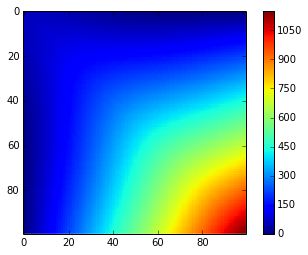

In [47]:
plt.imshow(K,interpolation='none')
plt.colorbar()

and sample functions from the marginal likelihood.

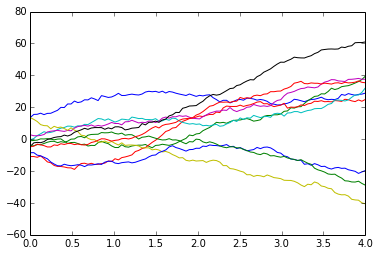

In [48]:
for i in xrange(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

The new covariance function doesn't have the problems with scaling exhibited by the the polynomial basis. We can reset our data from the olympics matrix and show samples computed across the actual years.

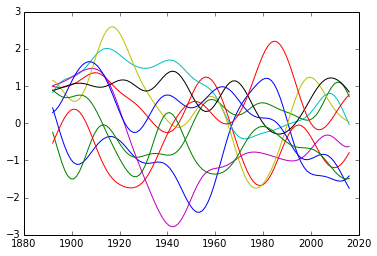

In [49]:
import urllib
url = ("http://staffwww.dcs.shef.ac.uk/"
    + "people/N.Lawrence/dataset_mirror/"
    + "olympic_marathon_men/olympicMarathonTimes.csv")
urllib.urlretrieve(url, 'olympicMarathonTimes.csv')
olympics = np.loadtxt('olympicMarathonTimes.csv', delimiter=',')
x = olympics[:, 0:1]
x_pred = linspace(1892, 2016, num_pred_data)[:, None]

def kern2(x, xprime, variance=1.0, lengthscale=1.0):
    return variance*np.exp((-0.5*(x - xprime)**2)/lengthscale**2)

alpha = 1.0
lengthscale = 10.
K = np.zeros((x_pred.size, x_pred.size))
for i in xrange(x_pred.size):
    for j in xrange(x_pred.size):
        K[i, j] = kern2(x_pred[i], x_pred[j], variance=alpha, lengthscale=lengthscale)


#plt.imshow(K,interpolation='none')
#plt.colorbar()      

for i in xrange(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

#### Moving Parameters

Have a play with the parameters for this covariance function and see what effects the parameters have on the types of functions you observe.

## Making Predictions

We now have a probability density that represents functions. How do we make predictions with this density? The density is known as a process because it is *consistent*. By consistency, here, we mean that the model makes predictions for $\mappingFunctionVector$ that are unaffected by future values of $\mappingFunctionVector^*$ that are currently unobserved (such as test points). If we think of $\mappingFunctionVector^\ast$ as test points, we can still write down a joint probability ensity over the training observations, $\mappingFunctionVector$ and the test observations, $\mappingFunctionVector^\ast$. This joint probability density will be Gaussian, with a covariance matrix given by our covariance function, $\kernelScalar(\inputVector_i, \inputVector_j)$. 

$$\begin{bmatrix}\mappingFunctionVector \\\ \mappingFunctionVector^\ast\end{bmatrix} \sim \gaussianSamp{\zerosVector}{\begin{bmatrix} \kernelMatrix & \kernelMatrix_\ast \\\ \kernelMatrix_\ast^\top & \kernelMatrix_{\ast,\ast}\end{bmatrix}}$$

where here $\kernelMatrix$ is the covariance computed between all the training points, $\kernelMatrix_\ast$ is the covariance matrix computed between the training points and the test points and $\kernelMatrix_{\ast,\ast}$ is the covariance matrix computed betwen all the tests points. To be clear, let's compute these now for our example, using `x` and `y` for the training data (although `y` doesn't enter the covariance) and `x_pred` as the test locations.

In [50]:
# set covariance function parameters
alpha = 16.0
lengthscale = 8
# set noise variance
sigma2 = 0.05

# compute covariance for training data, x
K = np.zeros((x.size, x.size))
for i in xrange(x.size):
    for j in xrange(x.size):
        K[i, j] = kern2(x[i], x[j], variance=alpha, lengthscale=lengthscale)

# compute covariance between training data, x, and test data, x_pred
K_star = np.zeros((x.size, x_pred.size))
for i in xrange(x.size):
    for j in xrange(x_pred.size):
        K_star[i, j] = kern2(x[i], x_pred[j], variance=alpha, lengthscale=lengthscale)
        
# compute covariance for test data, x_pred
K_starstar = np.zeros((x_pred.size, x_pred.size))
for i in xrange(x_pred.size):
    for j in xrange(x_pred.size):
        K_starstar[i, j] = kern2(x_pred[i], x_pred[j], variance=alpha, lengthscale=lengthscale)

The overall covariance between our training and test data can now be plotted as

<function matplotlib.pyplot.colorbar>

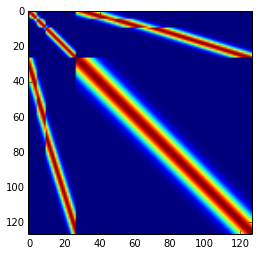

In [51]:
full_K = np.vstack([np.hstack([K, K_star]), np.hstack([K_star.T, K_starstar])])
plt.imshow(full_K)
plt.colorbar

The banded structure we now observe is because some of the training points are near to some of the test points. This is how we obtain 'communication' between our training data and our test data. If there is no structure in $\kernelMatrix_\ast$ then our belief about the test data simply matches our prior.

To make predictions about the test data we need the conditional distribution: $p(\mappingFunctionVector^\ast|\mappingFunctionVector)$, or when we include noise, $p(\mappingFunctionVector^\ast | \dataVector)$. This conditional distribution is also Gaussian,

$$\mappingFunctionVector^\ast \sim \gaussianSamp{\meanVector_\mappingFunctionScalar}{\covarianceMatrix_\mappingFunctionScalar}$$

 with a mean given by

$$\meanVector_\mappingFunctionScalar = \kernelMatrix^\top_\ast \left[\kernelMatrix + \dataStd^2 \eye\right]^{-1} \dataVector$$

and a covariance given by 

$$\covarianceMatrix_\mappingFunctionScalar = \kernelMatrix_{\ast,\ast} - \kernelMatrix^\top_\ast \left[\kernelMatrix + \dataStd^2 \eye\right]^{-1} \kernelMatrix_\ast.$$

These results can be proved using *block matrix inverse* rules, but they are beyond the scope of this course, so you don't need to worry about remembering them or rederiving them. We are simply writing them here because it is this *conditional* density that is necessary for making predictions. Let's compute what those predictions are for the olympic marathon data.

In [52]:
a = np.dot(np.linalg.inv(K + sigma2*eye(x.size)), K_star)
mu_f = np.dot(a.T, y)
C_f = K_starstar - np.dot(a.T, K_star)

where for convenience we've defined

$$\mathbf{a} = \left[\kernelMatrix + \dataStd^2\eye\right]^{-1}\kernelMatrix_\ast.$$ 

We can visualize the covariance of the *conditional*,

<function matplotlib.pyplot.colorbar>

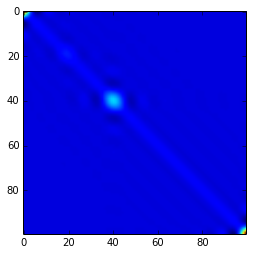

In [53]:
plt.imshow(C_f)
plt.colorbar

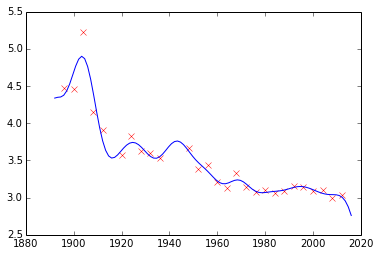

In [54]:
plt.plot(x, y, 'rx')
plt.plot(x_pred, mu_f, 'b-')

and we can plot the mean of the conditional

as well as the associated error bars. These are given (similarly to the Bayesian parametric model from the last lab) by the standard deviations of the marginal posterior densities. The marginal posterior variances are given by the diagonal elements of the posterior covariance,

In [55]:
var_f = np.diag(C_f)[:, None]
std_f = np.sqrt(var_f)

They can be added to the underlying mean function to give the error bars,

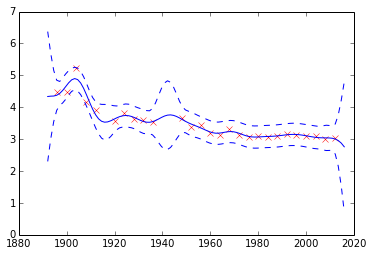

In [56]:
plt.plot(x, y, 'rx')
plt.plot(x_pred, mu_f, 'b-')
plt.plot(x_pred, mu_f+2*std_f, 'b--')
plt.plot(x_pred, mu_f-2*std_f, 'b--')

This gives us a prediction from the Gaussian process. Remember machine learning is data + model = prediction. Here our data is from the olympics, and our model is a Gaussian process with two parameters. The main thing the model expresses is smoothness. But it also sustains the uncertainty about the function, this means we see an increase in the size of the error bars during periods like the 1st and 2nd World Wars when no olympic marathon was held. 

### Exercises

Now try changing the parameters of the covariance function (and the noise) to see how the predictions change.

Now try sampling from this conditional density to see what your predictions look like. What happens if you sample from the conditional density in regions a long way into the future or the past? How does this compare with the results from the polynomial model?

# Gaussian Process models with GPy

## (section contains additional contributions by Nicolas Durrande and James Hensman

You've now had an idea of the Gaussian process predictive equations. In the next part of the lab you will move to GPy to fit the Gaussian process models. Note that the difficulties of the questions of the lab session varies. We do not mark these labs in any way, you should focus on the parts that you find most useful. **In this session you should try and complete at least as far as Exercise 5**.

## 1 Getting started: The Covariance Function

We assume that GPy is already installed on your machine. You can get instructions on how to install GPy from the  [SheffieldML github page](https://github.com/SheffieldML/GPy). They are written as markdown in the README.md file, which is automatically parsed for you just under the file listing there.

We first tell the ipython notebook that we want the plots to appear inline, then we import the libraries we will need:

In [57]:
%pylab inline
import numpy as np
import pylab as pb
import GPy

Populating the interactive namespace from numpy and matplotlib


The current draft of the online documentation of GPy is available from [this page](http://gpy.readthedocs.org/en/latest/).

Let's start with defining an exponentiated quadratic covariance function (also known as squared exponential or rbf or Gaussian) in one dimension:

In [58]:
d = 1          # input dimension
var = 10.       # variance
theta = 10.    # lengthscale
k = GPy.kern.RBF(d, variance=var, lengthscale=theta)# + GPy.kern.Brownian(1, variance=10)

A summary of the kernel can be obtained using the command `print k`. 

In [59]:
print k

  rbf.         |  Value  |  Constraint  |  Prior  |  Tied to
  variance     |   10.0  |     +ve      |         |         
  lengthscale  |   10.0  |     +ve      |         |         


It is also possible to plot the kernel as a function of one of its inputs (whilst fixing the other) with `k.plot()`. 

*Note*: if you need help with a command in ipython notebook, then you can get it at any time by typing a question mark after the command, e.g. `k.plot?`

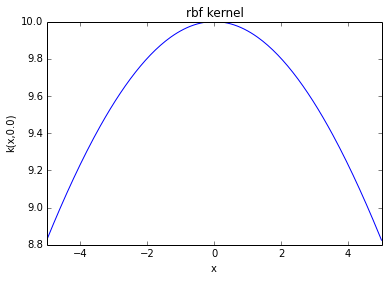

In [60]:
k.plot()

## Setting Covariance Function Parameters

The value of the covariance function parameters can be accessed and modified using `k['.*var']` where the string in bracket is a regular expression matching the parameter name as it appears in `print k`. Let's use this to get an insight into the effect of the parameters on the shape of the covariance function. 

We'll now use to set the lengthscale of the covariance to different values, and then plot the resulting covariance using the `k.plot()` method.

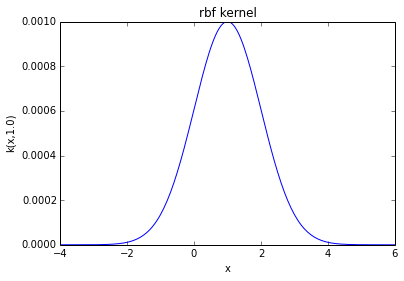

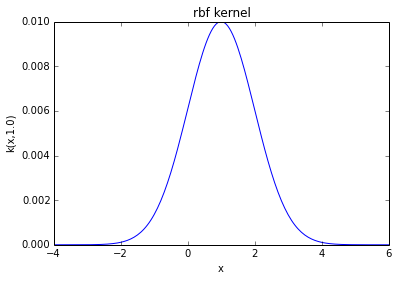

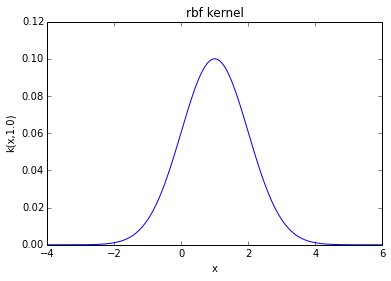

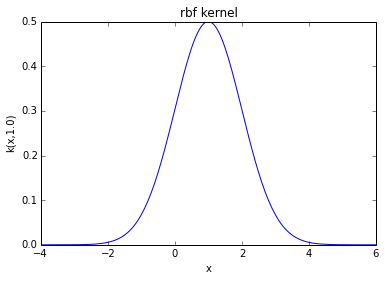

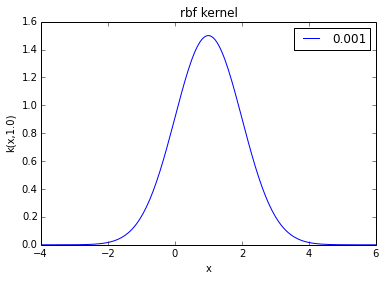

In [61]:
k = GPy.kern.RBF(d)     # By default, the parameters are set to 1.
theta = np.asarray([0.001,0.01,0.1,0.5,1.5])
#theta2 = np.asarray([0.2,1.2,2.2,3.2,4.2])
for t in theta:
    #k['.*lengthscale']=t 
    k['.*variance']=t
    k.plot(1.)
pb.legend(theta)

### Exercise 1

a) What is the effect of the lengthscale parameter on the covariance function?

b) Now change the code used above for plotting the covariances associated with the length scale to see the influence of the variance parameter. What is the effect of the the variance parameter on the covariance function?

## Covariance Functions in GPy

Many covariance functions are already implemented in GPy. Instead of rbf, try constructing and plotting the following  covariance functions: `exponential`, `Matern32`, `Matern52`, `Brownian`, `linear`, `bias`,
`rbfcos`, `periodic_Matern32`, etc. Some of these covariance functions, such as `rbfcos`, are not
parametrized by a variance and a lengthscale. Furthermore, not all kernels are stationary (i.e., they can’t all be written as $k ( x, y) = f ( x − y)$, see for example the Brownian
covariance function). For plotting  so it may be interesting to change the value of the fixed input:

(-0.1, 5.1)

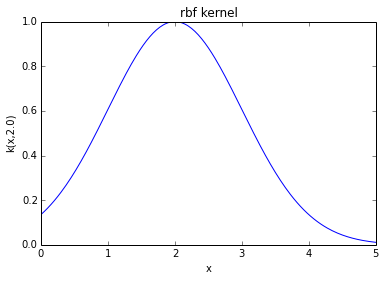

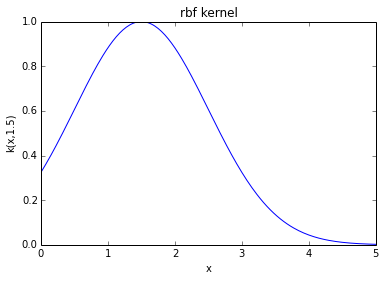

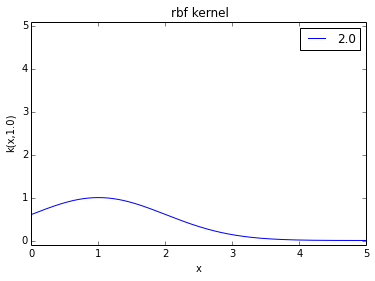

In [62]:
kb = GPy.kern.RBF(input_dim=1)
inputs = np.array([2., 1.5, 1.])
for x in inputs:
    kb.plot(x,plot_limits=[0,5])
pb.legend(inputs)
pb.ylim(-0.1,5.1)

## Computing the Covariance Function given the Input Data, $\mathbf{X}$

Let $\mathbf{X}$ be a $n$ × $d$ numpy array. Given a kernel $k$, the covariance matrix associated to
$\mathbf{X}$ is obtained with `C = k.K(X,X)` . The positive semi-definiteness of $k$ ensures that `C`
is a positive semi-definite (psd) matrix regardless of the initial points $\mathbf{X}$. This can be
checked numerically by looking at the eigenvalues:

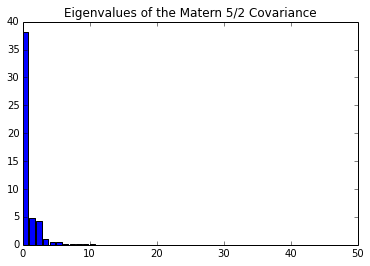

In [63]:
k = GPy.kern.Matern32(input_dim=2)
X = np.random.rand(50,2)       # 50*2 matrix of iid standard Gaussians
C = k.K(X,X)
eigvals = np.linalg.eigvals(C)           # Computes the eigenvalues of a matrix
plt.figure(1)
pb.bar(np.arange(len(eigvals)), eigvals)
title('Eigenvalues of the Matern 5/2 Covariance')
#print eigvals

## Combining Covariance Functions

### Exercise 2

a) A matrix, $\mathbf{K}$, is positive semi-definite if the matrix inner product, $\mathbf{x}^\top \mathbf{K}\mathbf{x}$ is greater than or equal to zero regardless of the values in $\mathbf{x}$. Given this it should be easy to see that the sum of two positive semi-definite matrices is also positive semi-definite. In the context of Gaussian processes, this is the sum of two covariance functions. What does this mean from a modelling perspective? 

*Hint*: there are actually two related interpretations for this. Think about the properties of a Gaussian distribution, and where the sum of Gaussian variances arises.

What about the element-wise product of two covariance functions? In other words if we define

\begin{align*}
k(\mathbf{x}, \mathbf{x}^\prime) = k_1(\mathbf{x}, \mathbf{x}^\prime) k_2(\mathbf{x}, \mathbf{x}^\prime)
\end{align*}

then is $k(\mathbf{x}, \mathbf{x}^\prime)$ a valid covariance function?

### Combining Covariance Functions in GPy

In GPy you can easily combine covariance functions you have created using the sum and product operators, `+` and `*`. So, for example, if we wish to combine an exponentiated quadratic covariance with a Matern 5/2 then we can write

  add.               |  Value  |  Constraint  |  Prior  |  Tied to
  rbf.variance       |    1.0  |     +ve      |         |         
  rbf.lengthscale    |    2.0  |     +ve      |         |         
  Mat52.variance     |    2.0  |     +ve      |         |         
  Mat52.lengthscale  |    4.0  |     +ve      |         |         


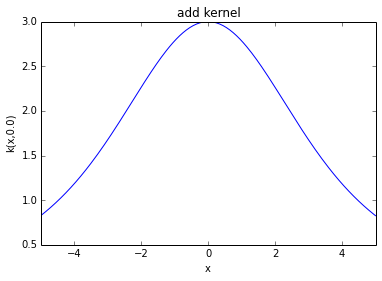

In [64]:
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern52(1, variance=2., lengthscale=4.)
kern = kern1 + kern2
print kern
kern.plot()

Or if we wanted to multiply them we can write

  mul.               |  Value  |  Constraint  |  Prior  |  Tied to
  rbf.variance       |    1.0  |     +ve      |         |         
  rbf.lengthscale    |    2.0  |     +ve      |         |         
  Mat52.variance     |    2.0  |     +ve      |         |         
  Mat52.lengthscale  |    4.0  |     +ve      |         |         


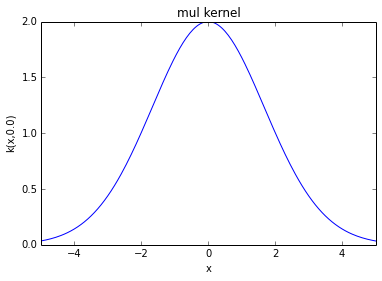

In [65]:
kern = kern1*kern2
print kern
kern.plot()

## 2 Sampling from a Gaussian Process

The Gaussian process provides a prior over an infinite dimensional function. It is defined by a covariance *function* and a mean *function*. When we compute the covariance matrix using `kern.K(X, X)` we are computing a covariance *matrix* between the values of the function that correspond to the input locations in the matrix `X`. If we want to have a look at the type of functions that arise from a particular Gaussian process we can never generate all values of the function, because there are infinite values. However, we can generate samples from a Gaussian *distribution* based on a covariance matrix associated with a particular matrix of input locations `X`. If these locations are chosen appropriately then they give us a good idea of the underlying function. For example, for a one dimensional function, if we choose `X` to be uniformly spaced across part of the real line, and the spacing is small enough, we'll get an idea of the underlying function. We will now use this trick to draw sample paths from a Gaussian process. 

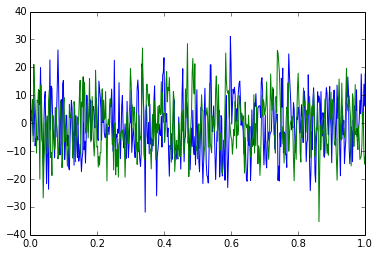

In [66]:
#k = GPy.kern.RBF(1, variance=.1, lengthscale=0.0001) #+ GPy.kern.Matern32(input_dim=1, variance=1., lengthscale=.1)
k = GPy.kern.Matern32(input_dim=1, variance=100., lengthscale=.002)
X = np.linspace(0., 1., 500)
X = X[:,None] # reshape X to make it n*p --- we try to use 'design matrices' in GPy 

mu = np.zeros((500)) # vector of the means --- we could use a mean function here, but here it is just zero.
C = k.K(X,X) # compute the covariance matrix associated with inputs X

# Generate 20 separate samples paths from a Gaussian with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)

pb.figure()     # open a new plotting window
for i in range(2):
    pb.plot(X[:],Z[i,:])

Our choice of `X` means that the points are close enough together to look like functions. We can see the structure of the covariance matrix we are plotting from if we visualize C.

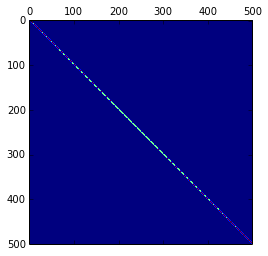

In [67]:
pb.matshow(C)

Now try a range of different covariance functions and values and plot the corresponding sample paths for each using the same approach given above.

In [68]:
# Try plotting sample paths here

### Exercise 3

Can you tell the covariance structures that have been used for generating the
sample paths shown in the figure below?
<br>
<center>
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figa.png" alt="Figure a" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figb.png" alt="Figure b" style="width: 30%;">
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figc.png" alt="Figure c" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figd.png" alt="Figure d" style="width: 30%;">
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/fige.png" alt="Figure e" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figf.png" alt="Figure f" style="width: 30%;">
</center>


## 3 A Gaussian Process Regression Model

We will now combine the Gaussian process prior with some data to form a GP regression model with GPy. We will generate data from the function $f ( x ) = − \cos(\pi x ) + \sin(4\pi x )$ over $[0, 1]$, adding some noise to give $y(x) = f(x) + \epsilon$, with the noise being Gaussian distributed, $\epsilon \sim \mathcal{N}(0, 0.01)$. 

In [69]:
np.random.normal(loc=0.0, scale=0.001)

0.002712573617044271

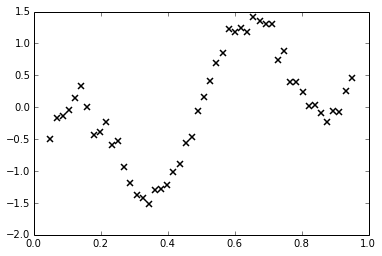

In [70]:
X = np.linspace(0.05,0.95,50)[:,None]
Y = -np.cos(np.pi*X) + np.sin(4*np.pi*X) + np.random.normal(loc=0.0, scale=0.1, size=(50,1))
Xp = np.linspace(0.05,0.50,50)[:,None] 
pb.figure()
pb.plot(X,Y,'kx',mew=1.5)

A GP regression model based on an exponentiated quadratic covariance function can be defined by first defining a covariance function, 

In [71]:
k = GPy.kern.Matern32(input_dim=1, variance=1.5, lengthscale=.2)

And then combining it with the data to form a Gaussian process model,

In [76]:
print Y.shape, X.shape
m = GPy.models.GPRegression(X,Y,k)
m['.*noise'] = 0.1

(50, 1) (50, 1)


Just as for the covariance function object, we can find out about the model using the command `print m`. 

In [73]:
print m


Name                 : GP regression
Log-likelihood       : -13.2369340926
Number of Parameters : 3
Parameters:
  GP_regression.           |  Value  |  Constraint  |  Prior  |  Tied to
  Mat32.variance           |    1.5  |     +ve      |         |         
  Mat32.lengthscale        |    0.2  |     +ve      |         |         
  Gaussian_noise.variance  |    0.1  |     +ve      |         |         


Note that by default the model includes some observation noise
with variance 1. We can see the posterior mean prediction and visualize the marginal posterior variances using `m.plot()`.

{'dataplot': [<matplotlib.lines.Line2D at 0x7f4a8810ad50>],
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f4a8858a910>],
  [<matplotlib.lines.Line2D at 0x7f4a8810a710>]]}

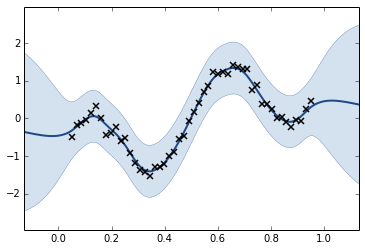

In [74]:
m.plot()

The actual predictions of the model for a set of points `Xstar`
(an $m \times p$ array) can be computed using `Ystar, Vstar, up95, lo95 = m.predict(Xstar)`

### Exercise 4

a) What do you think about this first fit? Does the prior given by the GP seem to be
adapted?

b) The parameters of the models can be modified using a regular expression matching the parameters names (for example `m['noise'] = 0.001` ). Change the values of the parameters to obtain a better fit.

In [108]:
# Exercise 4 b) answer For example if you fit the noise of the model to be the same as the noise of the Gaussian noise of
# the data you can obtain a better fit with less variance than before.

c) As in Section 2, random sample paths from the conditional GP can be obtained using
`np.random.multivariate_normal(mu[:,0],C)` where the mean vector and covariance
matrix `mu`, `C` are obtained through the predict function `mu, C, up95, lo95 = m.predict(Xp,full_cov=True)`. Obtain 10 samples from the posterior sample and plot them alongside the data below.

(50, 1)


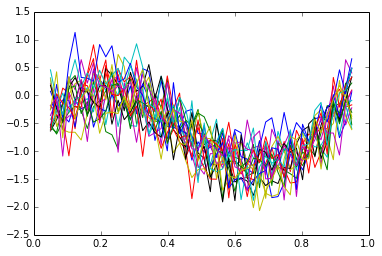

In [120]:
# Exercise 4 c)
mu, C = m.predict(Xp,full_cov=True)
print mu.shape
mmu = np.zeros(mu.shape[0])
mmu = mu[:,0]
Z = np.random.multivariate_normal(mmu,C,20)
pb.figure()     # open a new plotting window
for i in range(20):
    pb.plot(X[:],Z[i,:])

### Covariance Function Parameter Estimation

As we have seen during the lectures, the parameters values can be estimated by maximizing the likelihood of the observations. Since we don’t want one of the variance to become negative during the optimization, we can constrain all parameters to be positive before running the optimisation.

In [121]:
m.constrain_positive('.*') # Constrains all parameters matching .* to be positive, i.e. everything

The warnings are because the parameters are already constrained by default, the software is warning us that they are being reconstrained.

Now we can optimize the model using the `m.optimize()` method.


Name                 : GP regression
Log-likelihood       : 19.0054222285
Number of Parameters : 3
Parameters:
  GP_regression.           |       Value        |  Constraint  |  Prior  |  Tied to
  Mat32.variance           |    0.809791003966  |     +ve      |         |         
  Mat32.lengthscale        |     0.19676483208  |     +ve      |         |         
  Gaussian_noise.variance  |  0.00614842445191  |     +ve      |         |         


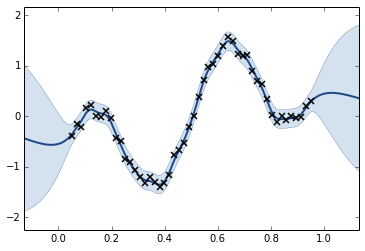

In [127]:
m.optimize()
m.plot()
print m

The parameters obtained after optimisation can be compared with the values selected by hand above. As previously, you can modify the kernel used for building the model to investigate its influence on the model.

## 4 The Running Example

Now we'll consider a small example with real world data, data giving the pace of all marathons run at the olympics. To load the data use

In [128]:
GPy.util.datasets.authorize_download = True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
print data['details']

Olympic mens' marathon gold medal winning times from 1896 to 2012. Time given in pace (minutes per kilometer). Data is originally downloaded and collated from Wikipedia, we are not responsible for errors in the data


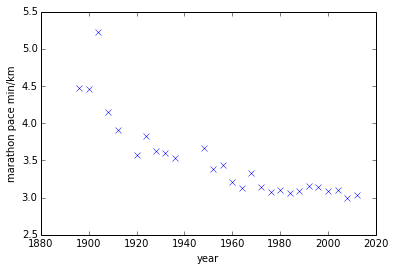

In [129]:
X = data['X']
Y = data['Y']
pb.plot(X, Y, 'bx')
pb.xlabel('year')
pb.ylabel('marathon pace min/km')

### Exercise 5

a) Build a Gaussian process model for the olympic data set using a combination of an exponentiated quadratic and a bias covariance function. Fit the covariance function parameters and the noise to the data. Plot the fit and error bars from 1870 to 2030. Do you think the predictions are reasonable? If not why not?


Name                 : GP regression
Log-likelihood       : -7.15604367801
Number of Parameters : 4
Parameters:
  GP_regression.           |       Value        |  Constraint  |  Prior  |  Tied to
  mul.rbf.variance         |  0.00265560059476  |     +ve      |         |         
  mul.rbf.lengthscale      |     150.354521977  |     +ve      |         |         
  mul.linear.variances     |  0.00265559957211  |     +ve      |         |         
  Gaussian_noise.variance  |   0.0488438774194  |     +ve      |         |         


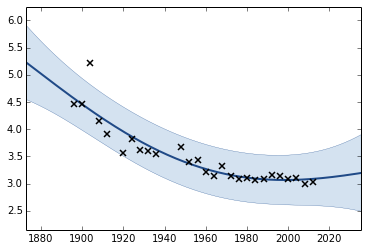

In [141]:
# Exercise 5 a) answer 
#kern = GPy.kern.RBF(1, lengthscale=20)*GPy.kern.Matern52(1, lengthscale=20) + GPy.kern.Bias(1)
kern = GPy.kern.RBF(1, lengthscale=80)*GPy.kern.Linear(1)# + GPy.kern.Bias(1)
model = GPy.models.GPRegression(X, Y, kern)
model.optimize()
model.plot()# Exercise 5 d) answer
model.log_likelihood()
print model

b) Fit the same model, but this time intialize the length scale of the exponentiated quadratic to 0.5. What has happened? Which of model has the higher log likelihood, this one or the one from (a)? 

*Hint:* use `model.log_likelihood()` for computing the log likelihood.

In [142]:
# Exercise 5 b) answer


c) Modify your model by including two covariance functions. Intitialize a covariance function with an exponentiated quadratic part, a Matern 3/2 part and a bias covariance. Set the initial lengthscale of the exponentiated quadratic to 80 years, set the initial length scale of the Matern 3/2 to 10 years. Optimize the new model and plot the fit again. How does it compare with the previous model? 

In [143]:
# Exercise 5 c) answer

d) Repeat part c) but now initialize both of the covariance functions' lengthscales to 20 years. Check the model parameters, what happens now? 

In [144]:
# Exercise 5 d) answer

e) Now model Model the data with a product of an exponentiated quadratic covariance function and a linear covariance function. Fit the covariance function parameters. Why are the variance parameters of the linear part so small? How could this be fixed?

In [145]:
# Exercise 5 e) answer

## 5 More Advanced: Uncertainty propagation

Let $x$ be a random variable defined over the real numbers, $\Re$, and $f(\cdot)$ be a function mapping between the real numbers $\Re \rightarrow \Re$. Uncertainty
propagation is the study of the distribution of the random variable $f ( x )$.

We will see in this section the advantage of using a model when only a few observations of $f$ are available. We consider here the 2-dimensional Branin test function
defined over [−5, 10] × [0, 15] and a set of 25 observations as seen in Figure 3.

In [146]:
# Definition of the Branin test function
def branin(X):
    y = (X[:,1]-5.1/(4*np.pi**2)*X[:,0]**2+5*X[:,0]/np.pi-6)**2
    y += 10*(1-1/(8*np.pi))*np.cos(X[:,0])+10
    return(y)

# Training set defined as a 5*5 grid:
xg1 = np.linspace(-5,10,5)
xg2 = np.linspace(0,15,5)
X = np.zeros((xg1.size * xg2.size,2))
for i,x1 in enumerate(xg1):
    for j,x2 in enumerate(xg2):
        X[i+xg1.size*j,:] = [x1,x2]

Y = branin(X)[:,None]

We assume here that we are interested in the distribution of $f (U )$ where $U$ is a
random variable with uniform distribution over the input space of $f$. We will focus on
the computation of two quantities: $E[ f (U )]$ and $P( f (U ) > 200)$.

### 4.1 Computation of E[ f (U )]

The expectation of $f (U )$ is given by $\int_x f ( x )\text{d}x$. A basic approach to approximate this
integral is to compute the mean of the 25 observations: `np.mean(Y)`. Since the points
are distributed on a grid, this can be seen as the approximation of the integral by a
rough Riemann sum. The result can be compared with the actual mean of the Branin
function which is 54.31.

Alternatively, we can fit a GP model and compute the integral of the best predictor
by Monte Carlo sampling:

In [150]:
# Fit a GP
# Create an exponentiated quadratic plus bias covariance function
kg = GPy.kern.RBF(input_dim=2, ARD = True)
kb = GPy.kern.Bias(input_dim=2)
k = kg + kb

# Build a GP model
m = GPy.models.GPRegression(X,Y,k,normalize_Y=True)

# constrain parameters to be bounded
m.constrain_bounded('.*rbf_var',1e-3,1e5)
m.constrain_bounded('.*bias_var',1e-3,1e5)
m.constrain_bounded('.*rbf_len',.1,200.)

# fix the noise variance
m.constrain_fixed('.*noise',1e-5)

# Randomize the model and optimize
m.randomize()
m.optimize()

# Plot the resulting approximation to Brainin
# Here you get a two-d plot becaue the function is two dimensional.
m.plot()

# Compute the mean of model prediction on 1e5 Monte Carlo samples
Xp = np.random.uniform(size=(1e5,2))
Xp[:,0] = Xp[:,0]*15-5
Xp[:,1] = Xp[:,1]*15
Yp = m.predict(Xp)[0]
np.mean(Yp)

TypeError: __init__() got an unexpected keyword argument 'normalize_Y'

### Exercise 6

a) Has the approximation of the mean been improved by using the GP model?

b) One particular feature of GPs we have not use for now is their prediction variance. Can you use it to define some confidence intervals around the previous result?

In [ ]:
# Exercise 6 b) answer

### 4.2 Computation of $P( f (U ) > 200)$

In various cases it is interesting to look at the probability that $f$ is greater than a given
threshold. For example, assume that $f$ is the response of a physical model representing
the maximum constraint in a structure depending on some parameters of the system
such as Young’s modulus of the material (say $Y$) and the force applied on the structure
(say $F$). If the later are uncertain, the probability of failure of the structure is given by
$P( f (Y, F ) > \text{f_max} )$ where $f_\text{max}$ is the maximum acceptable constraint.

### Exercise 7

a) As previously, use the 25 observations to compute a rough estimate of the probability that $f (U ) > 200$.

In [ ]:
# Exercise 7 a) answer

b) Compute the probability that the best predictor is greater than the threshold.

In [ ]:
# Exercise 7 b) answer

c) Compute some confidence intervals for the previous result

In [ ]:
# Exercise 7 c) answer

These two values can be compared with the actual value {$P( f (U ) > 200) = 1.23\times 10^{−2}$ .

We now assume that we have an extra budget of 10 evaluations of f and we want to
use these new evaluations to improve the accuracy of the previous result.

### Exercise 8

a) Given the previous GP model, where is it interesting to add the new observations if we want to improve the accuracy of the estimator and reduce its variance?

b) Can you think about (and implement!) a procedure that updates sequentially the model with new points in order to improve the estimation of $P( f (U ) > 200)$?

In [ ]:
# Exercise 8 b) answer